# EMA_short and EMA_long Crossover Backtest

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import talib as ta
from lightweight_charts import Chart
import asyncio
import nest_asyncio
from websockets import Close
import warnings

# Ignore all warnings from this point forward
warnings.filterwarnings('ignore')

nest_asyncio.apply()

In [2]:
# df = yf.download('TQQQ', start='2010-01-01', multi_level_index=False)
# df.reset_index(inplace=True)
# df.to_csv('TQQQ_data.csv', index=False)
df = pd.read_csv('TQQQ_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Close,High,Low,Open,Volume
0,2010-02-11,0.413438,0.415679,0.387651,0.388896,3456000
1,2010-02-12,0.415131,0.418715,0.399848,0.402187,8601600
2,2010-02-16,0.431211,0.432207,0.418217,0.424888,9619200
3,2010-02-17,0.438528,0.438628,0.430414,0.436986,19180800
4,2010-02-18,0.446842,0.449480,0.435442,0.438080,38860800


In [3]:
# Calculate EMA indicators
df['EMA_12'] = ta.EMA(df['Close'], timeperiod=12)
df['EMA_26'] = ta.EMA(df['Close'], timeperiod=26)
df['emabullish'] = np.where(df['EMA_12'] > df['EMA_26'], 1.0, 0.0)
df['crossover_EMA'] = df['emabullish'].diff()   

df = df.dropna().reset_index(drop=True)
df.head()

,Date,Close,High,Low,Open,Volume,EMA_12,EMA_26,emabullish,crossover_EMA
0,2010-03-19,0.530775,0.546256,0.525099,0.530775,20025600,0.514465,0.476282,1.0,1.0
1,2010-03-22,0.545112,0.551483,0.522560,0.524551,29395200,0.519180,0.481381,1.0,0.0
2,2010-03-23,0.556512,0.557707,0.540333,0.548845,27667200,0.524923,0.486946,1.0,0.0
3,2010-03-24,0.548596,0.553774,0.545112,0.552579,44620800,0.528565,0.491513,1.0,0.0
4,2010-03-25,0.545162,0.567862,0.544713,0.561988,46963200,0.531119,0.495487,1.0,0.0


In [4]:
if __name__ =='__main__':
    chart = Chart(title='TQQQ with EMA 12 and EMA 26', maximize=True)
    chart.legend(visible=True)

    chart.set(df)

    ema12_line = chart.create_line('EMA_12', color = '#ffeb3b', width = 1, price_label = True)
    ema12_line.set(df[['Date', 'EMA_12']])

    ema26_line = chart.create_line('EMA_26', color = '#26c6da', width = 1, price_label = True)
    ema26_line.set(df[['Date', 'EMA_26']])
    
    # Initialize a list to hold the markers
    markers = []

    # Iterate through the DataFrame to find crossover points
    for i in range(1, len(df)):

        ema_diff = df.iloc[i]['crossover_EMA']
        
        current_time = df.iloc[i]['Date']

        # Check for buy signal (EMA 12 crosses above EMA 25)
        if ema_diff == 1 :
            markers.append({
                'time': current_time,
                'position': 'below',
                'shape': 'arrow_up',
                'color': '#33de3d',
                'text': 'Buy'
            })
        
        # Check for sell signal (EMA 12 crosses below EMA 25)
        elif ema_diff == -1 :
            markers.append({
                'time': current_time,
                'position': 'above',
                'shape': 'arrow_down',
                'color': '#f485fb',
                'text': 'Sell'
            })

    # Add all markers at once. It's more efficient than adding them individually in a loop.
    if markers:
        chart.marker_list(markers)


    chart.show(block=True)


In [5]:
from backtesting import Backtest, Strategy

class EMACrossStrategy(Strategy):
    def init(self):
        # Calculate EMAs
        self.ema12 = self.I(ta.EMA, self.data.Close, 12)
        self.ema26 = self.I(ta.EMA, self.data.Close, 26)
    
    def next(self):
        if len(self.data) < 2:  # Skip first candle
            return
        
        # Check for buy signal (EMA 12 crosses above EMA 26)
        if (self.ema12[-2] <= self.ema26[-2] and 
            self.ema12[-1] > self.ema26[-1]):
            if not self.position:  # If not in position
                self.buy()
        
        # Check for sell signal (EMA 12 crosses below EMA 26)
        elif (self.ema12[-2] >= self.ema26[-2] and 
              self.ema12[-1] < self.ema26[-1]):
            if self.position:  # If in position
                self.position.close()

# Prepare data for backtesting
bt_data = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].copy()
bt_data.set_index('Date', inplace=True)

# Run backtest
bt = Backtest(bt_data, EMACrossStrategy,
              cash=10000,  # Initial capital
              commission=.002,  # Commission per trade (0.2%)
              exclusive_orders=True)  # Disallow concurrent orders

# Run the backtest and print results
results = bt.run()
print("\nBacktest Results:")
print("================")
print(f"Total Return: {results['Return [%]']:.2f}%")
print(f"Buy & Hold Return: {results['Buy & Hold Return [%]']:.2f}%")
print(f"Sharpe Ratio: {results['Sharpe Ratio']:.2f}")
print(f"Max Drawdown: {results['Max. Drawdown [%]']:.2f}%")
print(f"# Trades: {results['# Trades']}")
print(f"Win Rate: {results['Win Rate [%]']:.2f}%")
print(f"Profit Factor: {results['Profit Factor']:.2f}")

# Plot the backtest results
bt.plot()

Loading BokehJS ...


Backtest Results:
Total Return: 2068.51%
Buy & Hold Return: 16365.00%
Sharpe Ratio: 0.45
Max Drawdown: -55.24%
# Trades: 59
Win Rate: 42.37%
Profit Factor: 2.29


GridPlot(id='p1349', ...)

# Strategy Optimization
Let's optimize the EMA periods to find the best performing combination. We'll test different combinations of fast and slow EMAs.

In [6]:
class OptimizedEMACrossStrategy(Strategy):
    # Define parameters to optimize
    fast_ema = 12  # Default value
    slow_ema = 26  # Default value
    
    def init(self):
        # Calculate EMAs using the parameters
        self.ema_fast = self.I(ta.EMA, self.data.Close, self.fast_ema)
        self.ema_slow = self.I(ta.EMA, self.data.Close, self.slow_ema)
    
    def next(self):
        if len(self.data) < 2:
            return
        
        if (self.ema_fast[-2] <= self.ema_slow[-2] and 
            self.ema_fast[-1] > self.ema_slow[-1]):
            if not self.position:
                self.buy()
                
        elif (self.ema_fast[-2] >= self.ema_slow[-2] and 
              self.ema_fast[-1] < self.ema_slow[-1]):
            if self.position:
                self.position.close()

# Create a new Backtest instance for optimization
bt_opt = Backtest(bt_data, OptimizedEMACrossStrategy,
                 cash=10000,
                 commission=.002,
                 exclusive_orders=True)

# Run optimization with fewer combinations to prevent memory issues
optimization_results = bt_opt.optimize(
    fast_ema=range(5, 30, 2),    # Test EMAs from 5 to 30 with step of 2
    slow_ema=range(15, 50, 2),   # Test EMAs from 15 to 50 with step of 2
    maximize='Sharpe Ratio',      # Optimize for highest Sharpe Ratio
    constraint=lambda param: param.fast_ema < param.slow_ema  # Ensure fast EMA is shorter than slow EMA
)

# Get the best performing parameters
best_params = optimization_results._strategy

print("\nOptimization Results:")
print("===================")
print(f"Best Fast EMA Period: {best_params.fast_ema}")
print(f"Best Slow EMA Period: {best_params.slow_ema}")
print(f"Best Sharpe Ratio: {optimization_results['Sharpe Ratio']:.2f}")
print(f"Best Total Return: {optimization_results['Return [%]']:.2f}%")
print(f"Best Win Rate: {optimization_results['Win Rate [%]']:.2f}%")
print(f"Number of Trades: {optimization_results['# Trades']}")

# Run a new backtest with the optimal parameters
optimal_bt = Backtest(bt_data, OptimizedEMACrossStrategy,
                     cash=10000,
                     commission=.002,
                     exclusive_orders=True)

optimal_results = optimal_bt.run(
    fast_ema=best_params.fast_ema,
    slow_ema=best_params.slow_ema
)

# Plot the results with optimal parameters
optimal_bt.plot()

Backtest.run:   0%|          | 0/3882 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/3906 [00:00<?, ?bar/s]













Backtest.run:   0%|          | 0/3906 [00:00<?, ?bar/s]

























Backtest.run:   0%|          | 0/3876 [00:00<?, ?bar/s]
























































Backtest.run:   0%|          | 0/3882 [00:00<?, ?bar/s]




























                                                       










































                                                       























































Backtest.run:   0%|          | 0/3904 [00:00<?, ?bar/s]
























Backtest.run:   0%|          | 0/3892 [00:00<?, ?bar/s]










                                                       





Backtest.run:   0%|          | 0/3902 [00:00<?, ?bar/s]










































Backtest.run:   0%|          | 0/3878 [00:00<?, ?bar/s]






























Optimization Results:
Best Fast EMA Period: 13
Best Slow EMA Period: 19
Best Sharpe Ratio: 0.52
Best Total Return: 3225.83%
Best Win Rate: 47.06%
Number of Trades: 68


GridPlot(id='p1724', ...)

# Visualization of Optimization Results
Let's create a heatmap to visualize how different combinations of EMAs perform.

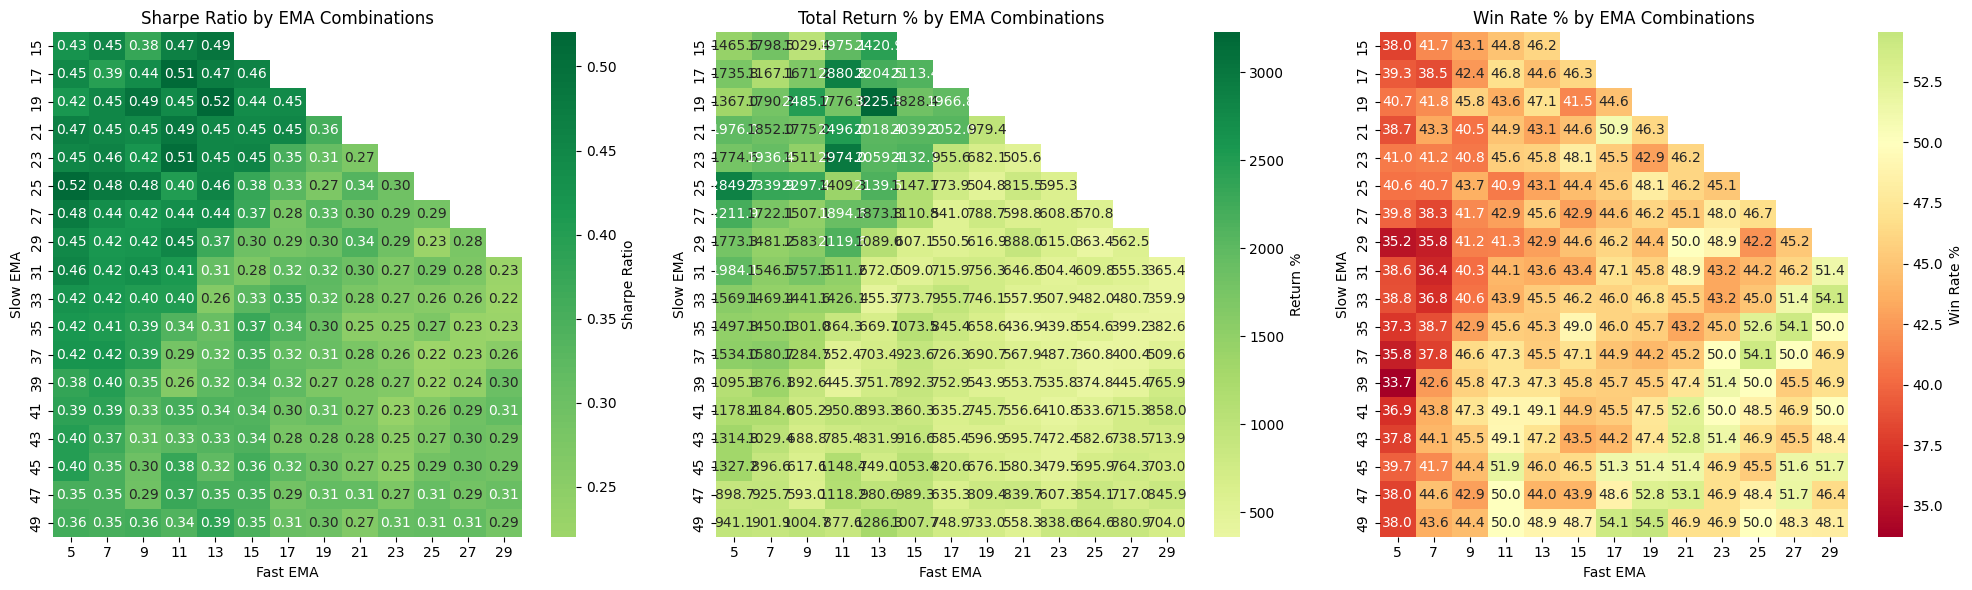


Top 10 Parameter Combinations by Sharpe Ratio:
 Fast EMA  Slow EMA  Sharpe Ratio  Return  Win Rate
       13        19          0.52 3225.83     47.06
        5        25          0.52 2849.73     40.62
       11        17          0.51 2880.81     46.84
       11        23          0.51 2974.01     45.59
        9        19          0.49 2485.67     45.78
       13        15          0.49 2420.90     46.15
       11        21          0.49 2495.97     44.93
        7        25          0.48 2339.89     40.70
        5        27          0.48 2211.92     39.78
        9        25          0.48 2297.37     43.66

Top 10 Parameter Combinations by Return:
 Fast EMA  Slow EMA  Sharpe Ratio  Return  Win Rate
       13        19          0.52 3225.83     47.06
       11        23          0.51 2974.01     45.59
       11        17          0.51 2880.81     46.84
        5        25          0.52 2849.73     40.62
       11        21          0.49 2495.97     44.93
        9        19       

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

try:
    # Extract results for heatmap
    heatmap_data = []
    
    # Get all optimization combinations
    for fast_ema in range(5, 30, 2):
        for slow_ema in range(15, 50, 2):
            if fast_ema < slow_ema:  # Respect our constraint
                # Run individual backtest for this combination
                result = bt_opt.run(
                    fast_ema=fast_ema,
                    slow_ema=slow_ema
                )
                heatmap_data.append({
                    'Fast EMA': fast_ema,
                    'Slow EMA': slow_ema,
                    'Sharpe Ratio': result['Sharpe Ratio'],
                    'Return': result['Return [%]'],
                    'Win Rate': result['Win Rate [%]']
                })

    # Convert to DataFrame for plotting
    heatmap_df = pd.DataFrame(heatmap_data)
    
    # Create subplots for multiple metrics
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot Sharpe Ratio heatmap
    pivot_sharpe = heatmap_df.pivot(index='Slow EMA', columns='Fast EMA', values='Sharpe Ratio')
    sns.heatmap(pivot_sharpe, cmap='RdYlGn', center=0, 
                annot=True, fmt='.2f',
                cbar_kws={'label': 'Sharpe Ratio'}, ax=axes[0])
    axes[0].set_title('Sharpe Ratio by EMA Combinations')
    
    # Plot Return heatmap
    pivot_return = heatmap_df.pivot(index='Slow EMA', columns='Fast EMA', values='Return')
    sns.heatmap(pivot_return, cmap='RdYlGn', center=0,
                annot=True, fmt='.1f',
                cbar_kws={'label': 'Return %'}, ax=axes[1])
    axes[1].set_title('Total Return % by EMA Combinations')
    
    # Plot Win Rate heatmap
    pivot_winrate = heatmap_df.pivot(index='Slow EMA', columns='Fast EMA', values='Win Rate')
    sns.heatmap(pivot_winrate, cmap='RdYlGn', center=50,
                annot=True, fmt='.1f',
                cbar_kws={'label': 'Win Rate %'}, ax=axes[2])
    axes[2].set_title('Win Rate % by EMA Combinations')
    
    plt.tight_layout()
    plt.show()

    # Print top 10 combinations by Sharpe Ratio
    print("\nTop 10 Parameter Combinations by Sharpe Ratio:")
    print("=========================================")
    top_10_sharpe = heatmap_df.sort_values('Sharpe Ratio', ascending=False).head(10)
    print(top_10_sharpe.round(2).to_string(index=False))
    
    # Print top 10 combinations by Return
    print("\nTop 10 Parameter Combinations by Return:")
    print("====================================")
    top_10_return = heatmap_df.sort_values('Return', ascending=False).head(10)
    print(top_10_return.round(2).to_string(index=False))
    
except Exception as e:
    print(f"Error creating visualization: {str(e)}")
    print("Please make sure the optimization has completed successfully before running this cell.")